In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import fsolve
from scipy.linalg import cho_solve, cho_factor
from scipy.interpolate import interp1d

from matplotlib import cm
from matplotlib.ticker import LinearLocator

## 1. Define S(Q,t) function

In [2]:
def f_sqt_chain(Q, t, N=100, b=1.0, D=1.0, tau_R=1.0, p_max=10):
    """
    Compute the scattering function S(Q, t) for a Gaussian polymer chain.

    Parameters:
        Q (numpy.ndarray): Scattering vector magnitude (1D array)
        t (numpy.ndarray): Time (1D array)
        N (int): Number of beads in the polymer chain (default 100)
        b (float): Bond length (default 1.0)
        D (float): Diffusion coefficient (default 1.0)
        tau_R (float): Relaxation time (default 1.0)
        p_max (int): Number of terms in the summation for Phi_nm^1 (default 50)

    Returns:
        numpy.ndarray: Value of S(Q, t) (1D array)
    """

    # Indices for polymer beads
    n_values, m_values = np.meshgrid(np.arange(N), np.arange(N))
    abs_nm = np.abs(n_values - m_values)

    # Compute Phi_nm(t) components
    Phi_D = 6 * D * t  # Center-of-mass diffusion
    Phi_nm_0 = abs_nm * b**2  # Gaussian chain contribution

    # Compute Phi_nm^1 (dynamic part)
    Phi_nm_1 = ((4 * N * b**2 / np.pi**2) * 
                np.sum([(1 / p**2) * np.einsum('ij,k->ijk', 
                                               np.cos(p * np.pi * n_values / N) * np.cos(p * np.pi * m_values / N), 
                                               (1 - np.exp(-t * p**2 / tau_R))) 
                        for p in range(1, p_max+1)], # sum over p
                       axis=0))
    
    # Total Phi_nm
    Phi_nm = Phi_D[None, None, :] + Phi_nm_0[:, :, None] + Phi_nm_1
    
    # Compute S(Q, t) using einsum
    Q_squared = Q**2  # Shape [i]
    Q_squared_expanded = Q_squared[None, None, :]  
    sqt = (1 / N) * np.einsum('ijk,ijk->k', np.exp(- (1/6) * Q_squared_expanded * Phi_nm), np.ones_like(Phi_nm))


    return sqt


### Calculate S(Q, t) for a range of Q and t values

In [3]:
n_Q = 21
n_t = 33
n_Qt = n_Q*n_t

b = 0.5
N = 20
D = 0.1
Rg = np.sqrt(N*b**2/6)

# QRg = np.linspace(0, 4, n_Q)
# Q = QRg/Rg

# # t = (np.arange(n_t))/n_t*12
# t = 10**(np.linspace(-3,1, n_t))
# Q_grid, t_grid = np.meshgrid(QRg, t)

QRg = np.random.uniform(0, 4, n_Qt)
Q = QRg / Rg

t = 10**(np.random.uniform(-3, 1, n_Qt))

sqt = f_sqt_chain(Q, t, N=N, b=b, D=D, tau_R=1.0, p_max=100)/N
sq0 = f_sqt_chain(Q, t*0, N=N, b=b, D=D, tau_R=1.0, p_max=100)/N


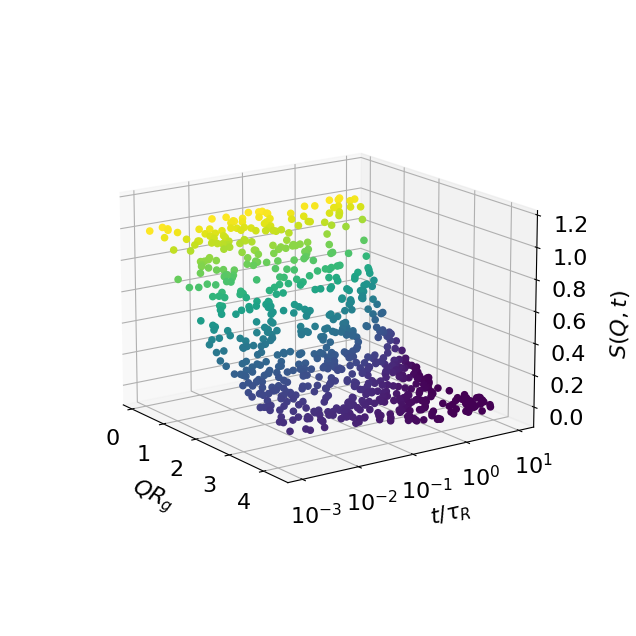

In [4]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.

# scatter = ax.scatter(Q_grid, np.log10(t_grid), sqt_exp.T-sqt_GT.T, color='k', alpha=0.5)

# surf_gt = ax.plot_surface(Q_grid, np.log10(t_grid), sqt_GT.T, alpha=1, cmap=cm.viridis)
ax.scatter(Q, np.log10(t), sqt, c=sqt, alpha=1)
        
# ax.plot(Q_grid[0,:], np.log10(t_grid)[0,:], np.zeros_like(Q_grid[0,:]), color='b', alpha=1)
# ax.plot(Q_grid[-1,:], np.log10(t_grid)[-1,:], np.zeros_like(Q_grid[0,:]), color='b', alpha=1)
# ax.plot(Q_grid[:,0], np.log10(t_grid)[:,0], np.zeros_like(Q_grid[:,0]), color='b', alpha=1)
# ax.plot(Q_grid[:,-1], np.log10(t_grid)[:,-1], np.zeros_like(Q_grid[:,0]), color='b', alpha=1)

# Customize the z axis.
# ax.set_zlim(-0.15, 0.15)

ax.set_xlabel(r'$QR_g$', fontsize=16, labelpad=25)
ax.set_ylabel(r'$t/\tau_R$', fontsize=16, labelpad=25)
ax.set_zlabel(r'$S(Q,t)$', fontsize=16, labelpad=25)

ax.set_yticks([-3, -2, -1, 0, 1])
ax.set_yticklabels([f'$10^{{{int(np.log10(y))}}}$' for y in [1e-3, 1e-2, 1e-1, 1e0, 1e1]])

ax.set_xticks([0, 1, 2, 3, 4])
ax.set_zlim(-0.1,1.2)

ax.tick_params(axis='both', which='major', labelsize=16, pad=10)
ax.set_box_aspect(None, zoom=0.75)
ax.view_init(16, 325)

# plt.tight_layout()

### Generate random distribured detector counts

In [5]:
def f_sqt_sample_Qt(Q, t, N_count=1000, N=100, b=1.0, D=1.0, tau_R=1.0, p_max=10, seed=None, bg = 0.01):
    """
    Compute the scattering function S(Q, t) for a Gaussian polymer chain.

    Parameters:
        Q (numpy.ndarray): Scattering vector magnitude (1D array)
        t (numpy.ndarray): Time (1D array)
        N_count (int): Number of counts for each Q (default 1000)
        N (int): Number of beads in the polymer chain (default 100)
        b (float): Bond length (default 1.0)
        D (float): Diffusion coefficient (default 1.0)
        tau_R (float): Relaxation time (default 1.0)
        p_max (int): Number of terms in the summation for Phi_nm_1 (default 50)
    Returns:
        numpy.ndarray: Value of S(Q, t) (1D array)
    """
    
    n_Qt = len(Q)
    
    np.random.seed(seed)
    sqt = f_sqt_chain(Q, t, N=N, b=b, D=D, tau_R=1.0, p_max=100)/N+bg
    
    pqt = sqt/np.sum(sqt)
    Nqt = N_count*pqt
    Delta_sqt = np.sqrt(Nqt)/N_count*np.sum(sqt)
    Delta_sqt_sample = Delta_sqt
    
    
    # Randomly choose indices based on the probability density
    indices = np.random.choice(n_Qt, size=N_count, p=pqt)
    
    # Get the sampled t and Q values    
    sqt_sample = np.zeros(n_Qt)
    for i in range(len(indices)):
        index = indices[i]
        sqt_sample[index] += 1
    sqt_sample = sqt_sample/N_count*np.sum(sqt)
    
    # for i in range(QRg.shape[0]):
    #     fit = (sqt)[:,i]+bg
    #     pit = fit/np.sum(fit)
    #     Nit = N_count*pit
    #     Delta_fit = np.sqrt(Nit)/N_count*np.sum(fit)
    #     Delta_sqt_sample[:,i] = Delta_fit
        
    #     bin_edges = np.linspace(0, len(t), len(t)+1)
    #     indices = np.random.choice(len(t), size=int(N_count), p=pit)
    #     N_sample_i, _ = np.histogram(indices, bins=bin_edges)
    #     sqt_sample_i = N_sample_i/N_count*np.sum(fit)
    #     sqt_sample[:,i] = sqt_sample_i
        
    return sqt_sample, Delta_sqt_sample, sqt

### Assign errorbar

In [6]:
bg = 0.002
N_count = n_Qt*100
seed = 114514

sqt_sample, Delta_sqt_sample, sqt = f_sqt_sample_Qt(Q, t, N_count=N_count, N=N, b=b, D=D, tau_R=1.0, p_max=100, seed=seed, bg = bg)
_, _, sq0 = f_sqt_sample_Qt(Q, t*0, N_count=N_count, N=N, b=b, D=D, tau_R=1.0, p_max=100, seed=seed, bg = bg)

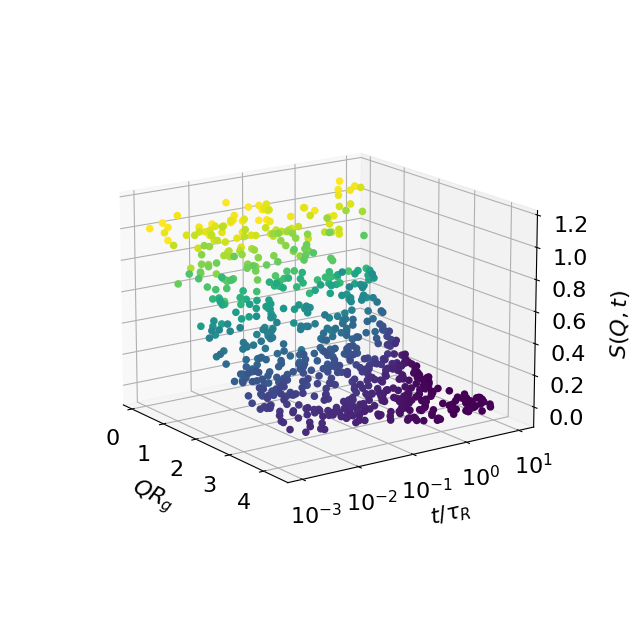

In [7]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.

# scatter = ax.scatter(Q_grid, np.log10(t_grid), sqt_exp.T-sqt_GT.T, color='k', alpha=0.5)

# surf_gt = ax.plot_surface(Q_grid, np.log10(t_grid), sqt_GT.T, alpha=1, cmap=cm.viridis)
ax.scatter(Q, np.log10(t), sqt_sample, c=sqt, alpha=1)
        
# ax.plot(Q_grid[0,:], np.log10(t_grid)[0,:], np.zeros_like(Q_grid[0,:]), color='b', alpha=1)
# ax.plot(Q_grid[-1,:], np.log10(t_grid)[-1,:], np.zeros_like(Q_grid[0,:]), color='b', alpha=1)
# ax.plot(Q_grid[:,0], np.log10(t_grid)[:,0], np.zeros_like(Q_grid[:,0]), color='b', alpha=1)
# ax.plot(Q_grid[:,-1], np.log10(t_grid)[:,-1], np.zeros_like(Q_grid[:,0]), color='b', alpha=1)

# Customize the z axis.
# ax.set_zlim(-0.15, 0.15)

ax.set_xlabel(r'$QR_g$', fontsize=16, labelpad=25)
ax.set_ylabel(r'$t/\tau_R$', fontsize=16, labelpad=25)
ax.set_zlabel(r'$S(Q,t)$', fontsize=16, labelpad=25)

ax.set_yticks([-3, -2, -1, 0, 1])
ax.set_yticklabels([f'$10^{{{int(np.log10(y))}}}$' for y in [1e-3, 1e-2, 1e-1, 1e0, 1e1]])

ax.set_xticks([0, 1, 2, 3, 4])
ax.set_zlim(-0.1,1.2)

ax.tick_params(axis='both', which='major', labelsize=16, pad=10)
ax.set_box_aspect(None, zoom=0.75)
ax.view_init(16, 325)

# plt.tight_layout()

## 2. Bayesian inference

In [8]:
def rbf_kernel(Q1, Q2, lambda_):
    """
    Compute the Radial Basis Function (RBF) kernel between points Q1 and Q2.
    """
    Q1 = np.asarray(Q1).reshape(-1, 1)
    Q2 = np.asarray(Q2).reshape(1, -1)
    return np.exp(-((Q1 - Q2)**2) / (2 * lambda_**2))

def construct_transformation_matrix(t, tau, bg_mode=False):
    """
    Compute the transformation matrix C_{a n}.
    """
    C = np.exp(-t[:, None] / tau[None, :])  # Shape (M, N)
    if bg_mode:
        C = np.hstack([np.ones((t.shape[0], 1)), C])
    return C

def bayesian_inference(S_exp, Q_obs, t_obs, Q_eval, t_eval, tau, delta_S_exp, mu_, lambda_, bg_mode=False):
    """
    Perform Bayesian inference and reconstruct the scattering function using Gaussian Process Regression.

    Parameters:
        S_exp (np.ndarray): Observed data array of shape (M,).
        Q_obs (np.ndarray): Observed spatial coordinates array of shape (M,).
        t_obs (np.ndarray): Observed temporal coordinates array of shape (M,).
        Q_eval (np.ndarray): Evaluation spatial points array of shape (L,).
        t_eval (np.ndarray): Evaluation temporal points array of shape (L,).
        tau (np.ndarray): Expansion parameters (relaxation times) array of shape (N,).
        delta_S_exp (np.ndarray): Measurement uncertainties array of shape (M,).
        mu_ (float): Mean of the prior distribution.
        lambda_ (float): Spatial kernel length-scale.
        bg_mode (bool): Flag to include background mode (default: False).

    Returns:
        tuple: 
            - A_GPR (np.ndarray): Posterior mean of expansion coefficients of shape (L, N).
            - K_GPR (np.ndarray): Posterior covariance matrix of shape (L, N, L, N).
            - S_reconstructed (np.ndarray): Estimated scattering function at evaluation points of shape (L,).
    """
    L, M, N = len(Q_eval), len(Q_obs), len(tau)

    # Compute normalized spatial kernel (M x L)
    spatial_kernel_raw = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * lambda_ ** 2))
    spatial_kernel = spatial_kernel_raw / spatial_kernel_raw.sum(axis=1, keepdims=True)

    # Compute temporal kernel (M x N)
    temporal_kernel = np.exp(-np.outer(t_obs, 1 / tau))

    # Construct design matrix G (M x LN) with proper normalization
    G = (spatial_kernel[:, :, None] * temporal_kernel[:, None, :]).reshape(M, L * N)

    # Include background mode if required
    if bg_mode:
        G = np.hstack([G, np.ones((M, 1))])

    # Compute prior covariance matrix (LN x LN)
    Q_dist = (Q_eval[:, None] - Q_eval[None, :]) ** 2
    spatial_prior_kernel = np.exp(-Q_dist / (2 * lambda_ ** 2))
    K_prior = np.kron(np.eye(N), spatial_prior_kernel)

    if bg_mode:
        K_prior = np.pad(K_prior, ((0, 1), (0, 1)), 'constant', constant_values=1e-8)

    # Compute measurement noise covariance matrix (M x M)
    Sigma = np.diag(delta_S_exp ** 2)

    # Compute posterior mean using Cholesky decomposition
    GK = G @ K_prior
    K_tilde = GK @ G.T + Sigma

    # Cholesky decomposition for numerical stability
    cho_K_tilde = cho_factor(K_tilde + 1e-8 * np.eye(M))
    A_GPR_flat = K_prior @ G.T @ cho_solve(cho_K_tilde, S_exp)

    # Reshape posterior mean to (L, N)
    A_GPR = A_GPR_flat.reshape(L, N)

    # Compute posterior covariance matrix (L, N, L, N)
    K_GPR_flat = K_prior - K_prior @ G.T @ cho_solve(cho_K_tilde, G @ K_prior)
    K_GPR = K_GPR_flat.reshape(L, N, L, N)

    # Reconstruct scattering function at evaluation points
    spatial_kernel_eval = np.exp(-((Q_eval[:, None] - Q_eval[None, :]) ** 2) / (2 * lambda_ ** 2))
    spatial_kernel_eval /= spatial_kernel_eval.sum(axis=1, keepdims=True)

    temporal_kernel_eval = np.exp(-np.outer(t_eval, 1 / tau))

    # Compute reconstructed scattering function (L,)
    S_reconstructed = np.einsum('ij,jn,in->i', spatial_kernel_eval, A_GPR, temporal_kernel_eval)

    return A_GPR, K_GPR, S_reconstructed


def bayesian_inference_ein(S_exp, Q_obs, t_obs, Q_eval, t_eval, tau, delta_S_exp, mu_, lambda_, bg_mode=False):
    """
    Perform Bayesian inference and reconstruct the scattering function using Gaussian Process Regression.

    Parameters:
        S_exp (np.ndarray): Observed data array of shape (A,).
        Q_obs (np.ndarray): Observed spatial coordinates array of shape (A,).
        t_obs (np.ndarray): Observed temporal coordinates array of shape (A,).
        Q_eval (np.ndarray): Evaluation spatial points array of shape (L,).
        t_eval (np.ndarray): Evaluation temporal points array of shape (L,).
        tau (np.ndarray): Expansion parameters (relaxation times) array of shape (N,).
        delta_S_exp (np.ndarray): Measurement uncertainties array of shape (A,).
        mu_ (float): Mean of the prior distribution.
        lambda_ (float): Spatial kernel length-scale.
        bg_mode (bool): Flag to include background mode (default: False).

    Returns:
        tuple: 
            - A_GPR (np.ndarray): Posterior mean of expansion coefficients of shape (L, N).
            - K_GPR (np.ndarray): Posterior covariance matrix of shape (L, N, L, N).
            - S_reconstructed (np.ndarray): Estimated scattering function at evaluation points of shape (L,).
    """
    L, A, N = len(Q_eval), len(Q_obs), len(tau)

    # Compute normalized spatial kernel (A x L)
    spatial_kernel_raw = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * lambda_ ** 2))
    spatial_kernel = spatial_kernel_raw / spatial_kernel_raw.sum(axis=1, keepdims=True)

    # Compute temporal kernel (A x N)
    temporal_kernel = np.exp(-np.outer(t_obs, 1 / tau))

    # Construct design matrix G (A x L x N)
    G = np.einsum('al,an->aln', spatial_kernel, temporal_kernel)

    # Include background mode if required
    if bg_mode:
        G = np.concatenate([G, np.ones((A, 1, 1))], axis=1)

    # Compute prior covariance matrix (L x N x L x N)
    Q_dist = (Q_eval[:, None] - Q_eval[None, :]) ** 2
    spatial_prior_kernel = np.exp(-Q_dist / (2 * lambda_ ** 2))
    K_prior = np.einsum('ij,nm->injm', spatial_prior_kernel, np.eye(N))
    K_prior = K_prior.reshape(L * N, L * N)

    # Compute measurement noise covariance matrix (A x A)
    Sigma = np.diag(delta_S_exp ** 2)

    # Compute posterior mean using Cholesky decomposition
    G_flat = G.reshape(A, L * N)
    K_tilde = np.einsum('ai,ij,bj->ab', G_flat, K_prior, G_flat) + Sigma

    # Cholesky decomposition for numerical stability
    cho_K_tilde = cho_factor(K_tilde + 1e-8 * np.eye(A))
    A_GPR_flat = K_prior @ G_flat.T @ cho_solve(cho_K_tilde, S_exp)

    # Reshape posterior mean to (L, N)
    A_GPR = A_GPR_flat.reshape(L, N)

    # Compute posterior covariance matrix (L, N, L, N)
    K_GPR_flat = K_prior - K_prior @ G_flat.T @ cho_solve(cho_K_tilde, G_flat @ K_prior)
    K_GPR = K_GPR_flat.reshape(L, N, L, N)

    # Reconstruct scattering function at evaluation points
    spatial_kernel_eval = np.exp(-((Q_eval[:, None] - Q_eval[None, :]) ** 2) / (2 * lambda_ ** 2))
    spatial_kernel_eval /= spatial_kernel_eval.sum(axis=1, keepdims=True)

    temporal_kernel_eval = np.exp(-np.outer(t_eval, 1 / tau))

    # Compute reconstructed scattering function (L,)
    S_reconstructed = np.einsum('ijn,in->j', np.einsum('ij,jn->ijn', spatial_kernel_eval, temporal_kernel_eval), A_GPR)

    return A_GPR, K_GPR, S_reconstructed

In [9]:
sqt_GT = sqt.T
sqt_exp = sqt_sample.T
delta_sqt_exp = Delta_sqt_sample.T
lambda_ = 0.075
mu_ = 0.075

N_Prony = 5
# list_tau_i = np.exp(np.linspace(-4,2,N_Prony))
list_tau_i = 10**(np.linspace(-1,3,N_Prony))
tau = np.array(list_tau_i)
bg_mode = True

# n_eval = 1000
# Q_eval = np.random.uniform(Q.min(), Q.max(), n_eval)
# t_eval = 10**(np.random.uniform(-3, 1, n_eval))
Q_eval = Q
t_eval = t

A_GPR, K_GPR, sqt_GPR = bayesian_inference(
    sqt_exp, Q, t, Q_eval, t_eval, tau, delta_sqt_exp, mu_, lambda_
)

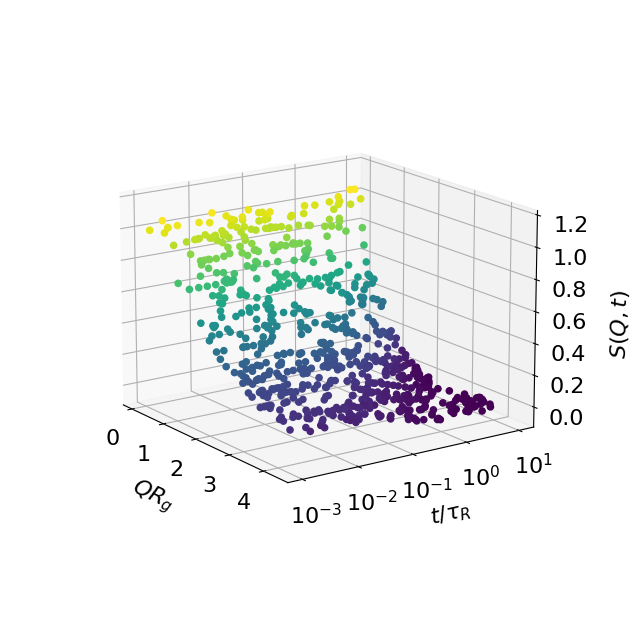

In [10]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.

# scatter = ax.scatter(Q_grid, np.log10(t_grid), sqt_exp.T-sqt_GT.T, color='k', alpha=0.5)

# surf_gt = ax.plot_surface(Q_grid, np.log10(t_grid), sqt_GT.T, alpha=1, cmap=cm.viridis)
# ax.scatter(Q, np.log10(t), sqt_GPR, c=sqt, alpha=1)
ax.scatter(Q_eval, np.log10(t_eval), sqt_GPR, c=sqt_GPR, alpha=1)
        
# ax.plot(Q_grid[0,:], np.log10(t_grid)[0,:], np.zeros_like(Q_grid[0,:]), color='b', alpha=1)
# ax.plot(Q_grid[-1,:], np.log10(t_grid)[-1,:], np.zeros_like(Q_grid[0,:]), color='b', alpha=1)
# ax.plot(Q_grid[:,0], np.log10(t_grid)[:,0], np.zeros_like(Q_grid[:,0]), color='b', alpha=1)
# ax.plot(Q_grid[:,-1], np.log10(t_grid)[:,-1], np.zeros_like(Q_grid[:,0]), color='b', alpha=1)

# Customize the z axis.
# ax.set_zlim(-0.15, 0.15)

ax.set_xlabel(r'$QR_g$', fontsize=16, labelpad=25)
ax.set_ylabel(r'$t/\tau_R$', fontsize=16, labelpad=25)
ax.set_zlabel(r'$S(Q,t)$', fontsize=16, labelpad=25)

ax.set_yticks([-3, -2, -1, 0, 1])
ax.set_yticklabels([f'$10^{{{int(np.log10(y))}}}$' for y in [1e-3, 1e-2, 1e-1, 1e0, 1e1]])

ax.set_xticks([0, 1, 2, 3, 4])
ax.set_zlim(-0.1,1.2)

ax.tick_params(axis='both', which='major', labelsize=16, pad=10)
ax.set_box_aspect(None, zoom=0.75)
ax.view_init(16, 325)

# plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Text(0, -3, '$10^{-3}$'), Text(0, 1, '$10^{1}$')]

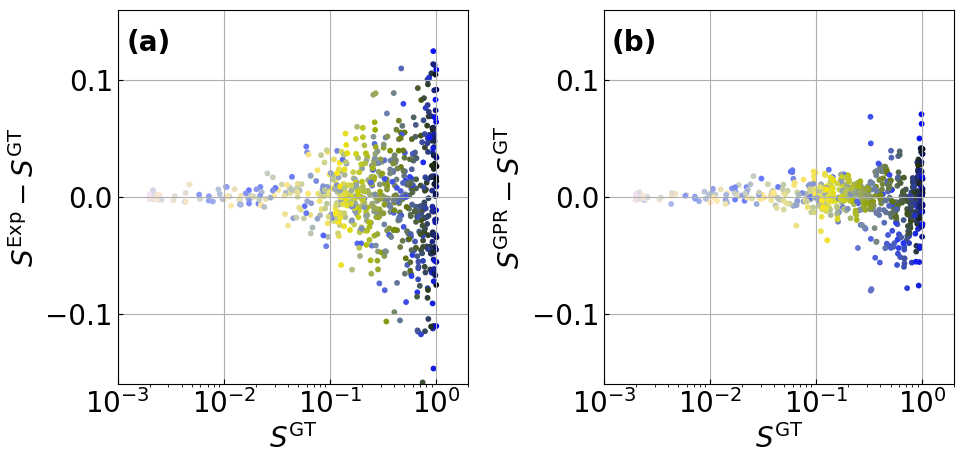

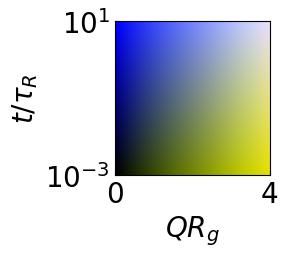

In [11]:
panels_list = ['(a)', '(b)', '(c)']

# Create a 2D RGB color scheme
norm = plt.Normalize(vmin=Q.min(), vmax=Q.max())
norm_t = plt.Normalize(vmin=np.log10(t).min(), vmax=np.log10(t).max())
colors = plt.cm.viridis(norm(Q))
colors[:, 0] = norm(Q)  # Red channel controlled by Q
colors[:, 2] = norm_t(np.log10(t))  # Blue channel controlled by log10(t)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.scatter(sqt, (sqt_exp-sqt), s=10, c=colors)
ax.set_xlabel('$S^\mathrm{GT}$', fontsize=20)
ax.set_ylabel('$S^\mathrm{Exp}-S^\mathrm{GT}$', fontsize=20)
ax.tick_params(direction='in', labelsize=20)
ax.set_xlim(1e-3,2)
ax.set_ylim(-0.16,0.16)
ax.set_xscale('log')
ax.grid('on')
ax.text(0.15, 0.95, panels_list[0], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right', color='k')

ax = fig.add_subplot(122)
ax.scatter(sqt, (sqt_GPR-sqt), s=10, c=colors)
ax.set_xlabel('$S^\mathrm{GT}$', fontsize=20)
ax.set_ylabel('$S^\mathrm{GPR}-S^\mathrm{GT}$', fontsize=20)
ax.tick_params(direction='in', labelsize=20)
ax.set_xlim(1e-3,2)
ax.set_ylim(-0.16,0.16)
ax.set_xscale('log')
ax.grid('on')
ax.text(0.15, 0.95, panels_list[1], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right', color='k')

plt.tight_layout(pad=2)

fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111)

q_grid = np.linspace(0, 4, 100)
t_grid = 10**(np.linspace(-3,1, 100))
Q_grid, t_grid = np.meshgrid(q_grid, t_grid)
colors = plt.cm.viridis(norm(Q_grid))
colors[:, :, 0] = norm(Q_grid)  # Red channel controlled by Q
colors[:, :, 2] = norm_t(np.log10(t_grid))  # Blue channel controlled by log10(t)
ax.imshow(colors, extent=(0, 4, -3, 1), aspect='auto', origin='lower')
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$QR_g$', fontsize=20)
ax.set_ylabel(r'$t/\tau_R$', fontsize=20)
ax.set_xticks([0, 4])
ax.set_yticks([-3, 1])
ax.set_xticklabels([f'{i}' for i in [0, 4]])
ax.set_yticklabels([f'$10^{{{int(np.log10(y))}}}$' for y in [1e-3, 1e1]])


In [12]:
t_grid

array([[1.00000000e-03, 1.00000000e-03, 1.00000000e-03, ...,
        1.00000000e-03, 1.00000000e-03, 1.00000000e-03],
       [1.09749877e-03, 1.09749877e-03, 1.09749877e-03, ...,
        1.09749877e-03, 1.09749877e-03, 1.09749877e-03],
       [1.20450354e-03, 1.20450354e-03, 1.20450354e-03, ...,
        1.20450354e-03, 1.20450354e-03, 1.20450354e-03],
       ...,
       [8.30217568e+00, 8.30217568e+00, 8.30217568e+00, ...,
        8.30217568e+00, 8.30217568e+00, 8.30217568e+00],
       [9.11162756e+00, 9.11162756e+00, 9.11162756e+00, ...,
        9.11162756e+00, 9.11162756e+00, 9.11162756e+00],
       [1.00000000e+01, 1.00000000e+01, 1.00000000e+01, ...,
        1.00000000e+01, 1.00000000e+01, 1.00000000e+01]])

## Figure: MSE_count

In [13]:
n_repeat = 1
list_N_count = np.logspace(3.5,6.5,16).astype(int)
list_chi_sq_exp_gt = []
list_chi_sq_GPR_gt = []
list_mse_exp_gt = []
list_mse_GPR_gt = []
for N_count in list_N_count:
    mse_exp_gt = 0
    mse_GPR_gt = 0
    chi_sq_exp_gt = 0
    chi_sq_GPR_gt = 0
    for i in range(n_repeat):
        sqt_sample, Delta_sqt_sample, sqt = f_sqt_sample_Qt(Q, t, N_count=N_count, N=N, b=b, D=D, tau_R=1.0, p_max=100, seed=seed, bg = bg)
        sqt_GT = sqt
        sqt_exp = sqt_sample
        delta_sqt_exp = Delta_sqt_sample
        A_GPR, K_GPR, sqt_GPR = bayesian_inference(
                sqt_exp, Q, t, Q, t, tau, delta_sqt_exp, mu_, lambda_
            )
    
        mse_exp_gt += np.mean((sqt_exp-sqt_GT)**2)
        mse_GPR_gt += np.mean((sqt_GPR-sqt_GT)**2)
        
        chi_sq_exp_gt += np.mean((sqt_exp-sqt_GT)**2/delta_sqt_exp**2)
        chi_sq_GPR_gt += np.mean((sqt_GPR-sqt_GT)**2/delta_sqt_exp**2)
    
    mse_exp_gt /= n_repeat
    mse_GPR_gt /= n_repeat
    chi_sq_exp_gt /= n_repeat
    chi_sq_GPR_gt /= n_repeat
    
    list_chi_sq_exp_gt.append(chi_sq_exp_gt)
    list_chi_sq_GPR_gt.append(chi_sq_GPR_gt)
    list_mse_exp_gt.append(mse_exp_gt)
    list_mse_GPR_gt.append(mse_GPR_gt)

In [14]:
# plot the time required for the GPR and the experimental data to reach the same relative entropy
f_interp_gpr = interp1d(np.log(list_mse_GPR_gt), np.log(list_N_count), kind='linear', fill_value='extrapolate')

time_gpr = np.zeros_like(list_N_count)
for i in range(len(list_mse_exp_gt)):
    H_exp_gt_i = np.log(list_mse_exp_gt[i])
    time_gpr[i] = np.exp(f_interp_gpr(H_exp_gt_i))

In [15]:
from scipy.optimize import curve_fit

# plot the time required for the GPR and the experimental data to reach the same relative entropy
# fit the log(list_N_count) - log(list_mse_GPR_gt) with a linear function
def linear_func(x, a, b):
    return a * x + b

# Fit the data for GPR
popt_gpr, pcov_gpr = curve_fit(linear_func, np.log(list_N_count), np.log(list_mse_GPR_gt))
# Generate x values for the fitted line
x_fit_gpr = np.linspace(np.log(list_N_count[0]), np.log(list_N_count[-1]), 100)
# Calculate the fitted y values
y_fit_gpr = linear_func(x_fit_gpr, *popt_gpr)

# Fit the data for Exp
popt_exp, pcov_exp = curve_fit(linear_func, np.log(list_N_count), np.log(list_mse_exp_gt))
# Generate x values for the fitted line
x_fit_exp = np.linspace(np.log(list_N_count[0]), np.log(list_N_count[-1]), 100)
# Calculate the fitted y values
y_fit_exp = linear_func(x_fit_exp, *popt_exp)

# Estimate the x_fit_gpr and x_fit_exp given the same y
y_target_values = np.linspace(np.min(np.log(list_mse_GPR_gt)), np.max(np.log(list_mse_GPR_gt)), 10)
y_target_values = np.log(list_mse_GPR_gt)

N_count_est_gpr_values = []
N_count_est_exp_values = []
list_ratio_N = []

for y_target in y_target_values:
    # Find the corresponding x values for the target y value
    x_est_gpr = (y_target - popt_gpr[1]) / popt_gpr[0]
    x_est_exp = (y_target - popt_exp[1]) / popt_exp[0]

    # Convert the log values back to the original scale
    N_count_est_gpr = np.exp(x_est_gpr)
    N_count_est_exp = np.exp(x_est_exp)

    N_count_est_gpr_values.append(N_count_est_gpr)
    N_count_est_exp_values.append(N_count_est_exp)
    ratio_N = N_count_est_exp/N_count_est_gpr
    list_ratio_N.append(ratio_N)

print("Estimated N_count for GPR:", N_count_est_gpr_values)
print("Estimated N_count for Exp:", N_count_est_exp_values)

Estimated N_count for GPR: [2542.9861507860332, 4288.297706648431, 10407.911400749637, 13358.874965905206, 20902.397349447725, 33789.230396262166, 50399.55849048355, 81616.09742897934, 124270.4144579857, 202895.8305564542, 298279.9374883244, 524061.76252914604, 801338.4635619294, 1186773.7103580448, 1947935.5571557225, 3107976.8976229434]
Estimated N_count for Exp: [21885.95211594837, 33163.11984095308, 67129.73079596566, 81871.40729672092, 116886.05187097394, 171258.29547621892, 235373.2649782423, 345347.23356022243, 482474.5435869755, 712527.4913479914, 968051.859675521, 1515511.072846966, 2124428.83163483, 2903253.7784940205, 4305687.217035714, 6243308.541401531]


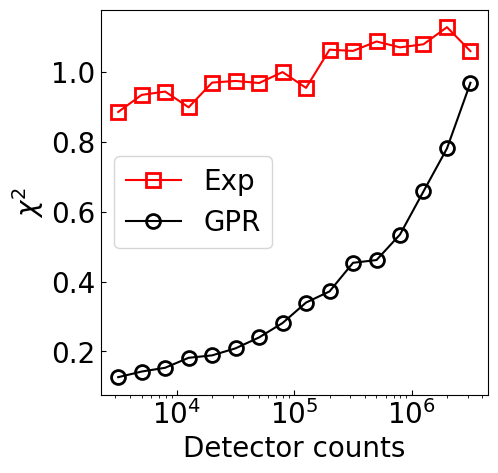

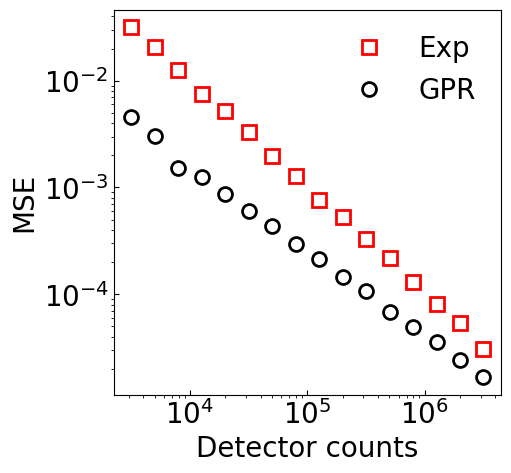

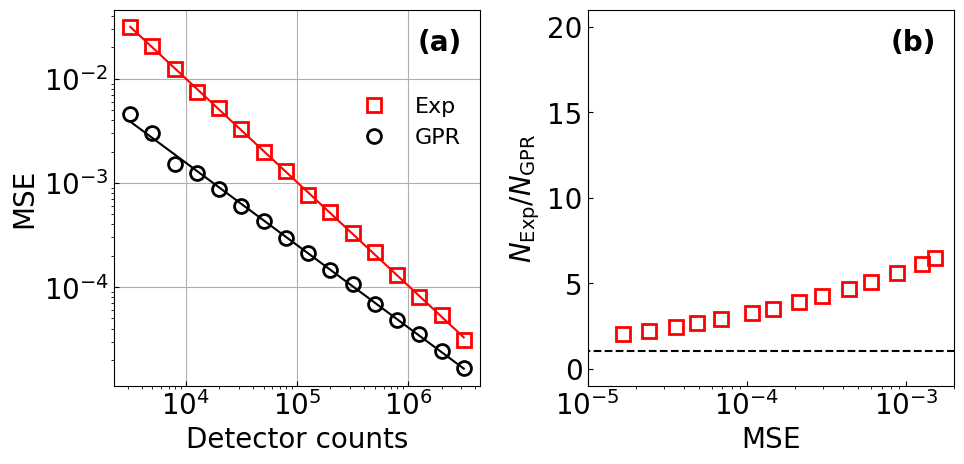

In [16]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

ax.plot(list_N_count, list_chi_sq_exp_gt, '-s', color='r',  fillstyle='none', ms=10, markeredgewidth=2, label='Exp')
ax.plot(list_N_count, list_chi_sq_GPR_gt, '-o', color='k',  fillstyle='none', ms=10, markeredgewidth=2, label='GPR')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('Detector counts', fontsize=20)
ax.set_ylabel(r'$\chi^2$', fontsize=20)
ax.tick_params(direction='in', labelsize=20)
ax.legend(fontsize=20)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

ax.plot(list_N_count, list_mse_exp_gt, 's', color='r',  fillstyle='none', ms=10, markeredgewidth=2, label='Exp')
ax.plot(list_N_count, list_mse_GPR_gt, 'o', color='k',  fillstyle='none', ms=10, markeredgewidth=2, label='GPR')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Detector counts', fontsize=20)
ax.set_ylabel('MSE', fontsize=20)
ax.tick_params(direction='in', labelsize=20)
ax.legend(fontsize=20, frameon=False)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)

ax.plot(list_N_count, list_mse_exp_gt, 's', color='r',  fillstyle='none', ms=10, markeredgewidth=2, label='Exp')
ax.plot(np.exp(x_fit_exp), np.exp(y_fit_exp), '-', color='r',  fillstyle='none', ms=10, markeredgewidth=2)
ax.plot(list_N_count, list_mse_GPR_gt, 'o', color='k',  fillstyle='none', ms=10, markeredgewidth=2, label='GPR')
ax.plot(np.exp(x_fit_gpr), np.exp(y_fit_gpr), '-', color='k',  fillstyle='none', ms=10, markeredgewidth=2)
ax.grid('on')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Detector counts', fontsize=20)
ax.set_ylabel('MSE', fontsize=20)
ax.tick_params(direction='in', labelsize=20)
ax.legend(fontsize=16, frameon=False, loc='right', bbox_to_anchor=(1, 0.7))
ax.text(0.95, 0.95, panels_list[0], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right', color='k')

ax = fig.add_subplot(122)
ax.plot(np.exp(y_target_values), list_ratio_N, 's', color='r',  fillstyle='none', ms=10, markeredgewidth=2, label = r'$t_\mathrm{GPR}$')
ax.plot([1e-6,1e-2], [1, 1], '--', color='k',  fillstyle='none', ms=10, markeredgewidth=2, label = r'$t_\mathrm{Exp}$')

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim([2e-5,2e-3])
ax.set_ylim([-1, 21])
ax.tick_params(direction='in', labelsize=20)
ax.set_xticks([1e-5,1e-4,1e-3])
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$\mathrm{MSE}}$', fontsize=20)
ax.set_ylabel(r'$N_\mathrm{Exp}/N_\mathrm{GPR}$', fontsize=20)
# ax.legend(frameon=False, fontsize=14, loc = 'upper left')
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=9)
ax.xaxis.set_minor_locator(locmin)
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)
ax.text(0.95, 0.95, panels_list[1], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right', color='k')

plt.tight_layout(pad=2)

# fig = plt.figure(figsize=(10,5))
# ax = fig.add_subplot(121)

# ax.plot(time_gpr, list_mse_exp_gt, '-s', color='r',  fillstyle='none', ms=10, markeredgewidth=2, label='Exp')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel('Detector counts', fontsize=20)
# ax.set_ylabel('MSE', fontsize=20)
# ax.tick_params(direction='in', labelsize=20)
# ax.legend(fontsize=20, frameon=False)